#### VLP Size Distribution Script - Multiple Images

This script can be used for generating rough distribution of vlp radii from an electron microscope images. At the least, it provides a distibution of a sample of particles from the images. For this script to work it is assumed that all images are of the same scale, and have similar image characteristics. If any images are markedly different from the others, we recommed using the single image script to fine tune the algorithm for that particular image.

The following packages are necessary to run this script:

 - python 3.5 with numpy and matplotlib
 - opencv3
 
Furthermore, the folder containing this notebook should contain an additional folder containing the images you would like to process.

Enjoy!

----------------------------

1) Import necessary packages - an error here will require installing the dependencies listed above.

In [1]:
import cv2
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

2) Specify the name of the subfolder which contains the images.

If the printed list of filenames is not correct, some mild manual preprocessing may be necessary!

In [2]:
# ---- Enter folder name here -----

folder_name = "named_images"

# ------------------------------

location = os.getcwd() + "/"+folder_name +"/" 
filenames = [filename for filename in os.listdir(location)]

if ".DS_Store" in filenames:
    filenames.remove(".DS_Store")

print("Are these filenames correct:")
print()
for filename in filenames:
    print(filename)

Are these filenames correct:

1.jpg
10.jpg
11.jpg
12.jpg
2.jpg
3.jpg
4.jpg
5.jpg
6.jpg
7.jpg
8.jpg
9.jpg


3) Set the scale for the images:

Adjust the top/left/right parameters until the white bar is the same length as the scale bar of the image. It is also necessary to provide the stated length of the scale bar (in nm). If the scale bar is not situated in the bottom left of the image then the measuring sub-image will need to be manually calibrated.

NBNB: All images in the folder need to have the same scale :)

Your bar is  164 pixels long. The pixel to nm ratio is:  0.3048780487804878


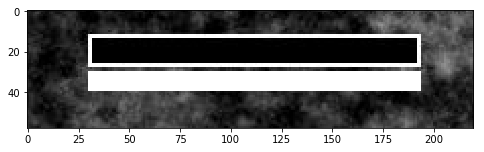

In [3]:
#---- Enter the parameters here ------

size_of_scalebar_in_nm = 50
top = 30
left = 30
right = 194

#-------------------------------------

raw_image = cv2.imread(location+filenames[0],0)
measure = raw_image.copy()
measure = measure[1990:,0:220]
measure[top:top+10,left:right]=255

plt.figure(figsize=(8,8))
plt.imshow(measure,cmap='gray')

ptnm = size_of_scalebar_in_nm/(right-left)
print("Your bar is ", right-left, "pixels long. The pixel to nm ratio is: ", ptnm )

5) Set the algorithm parameters:

Basically, a blockwise median filter is applied to the image (well suited for smoothing greyscale static noise), after which the opencv HoughCircle detector method is used. There are multiple parameters which need to be selected - play around with these settings to get optimal performance:

 - pixel_filter_width: This determines the size (in pixels) of the square filter used for median filtering of the image - must be an odd number!
 - min_radius_in_nm: The minimum radius (in nm) you would like the algorithm to detect.
 - max_radius_in_nm: The maximum radius (in nm) you would like the algorithm to detect.
 - min-seperation_in_pixels: The minimum distance (in pixels) between detected circles. By default we set this to twice the minimum radius, to mitigate the detection of overlapping circles.
 - tuning_param_1: Controls the sensitivity of the algorithm to gradient contours.
 - tuning_param_2: Controls the sensitivity of the algorithm.

In [4]:
# ---- Enter the parameters here -------

pixel_filter_width = 21                   # Higher number gives blurrier smoothing - recommond 11 to 21 (must be odd!)
min_radius_in_nm = 4                    
max_radius_in_nm = 18
tuning_param_1 = 35                        # Higher number gives less sensitive detection - recommend 30 to 50
tuning_param_2 = 25                        # Higher number gives less sensitive detection - recommend 18 to 35

min_seperation_in_pixels = int(np.floor((2*min_radius_in_nm)/ptnm))


# ------ Good starting point parameters for reference ------

# pixel_filter_width = 21
# min_radius_in_nm = 4
# max_radius_in_nm = 18
# min_seperation_in_pixels = 25
# tuning_param_1 = 40
# tuning_param_2 = 19

6) Define the helper functions and run the algorithm!

In [5]:
# ------- helper functions -----------

def find_circles(raw_image):
    
    min_radius_in_pixels = int(np.floor(min_radius_in_nm/ptnm))
    max_radius_in_pixels = int(np.ceil(max_radius_in_nm/ptnm))

    mf_image = cv2.medianBlur(raw_image,21)
    circles = cv2.HoughCircles(mf_image,cv2.HOUGH_GRADIENT,1,
                           min_seperation_in_pixels,
                           param1=tuning_param_1,
                           param2=tuning_param_2,
                           minRadius=min_radius_in_pixels,
                           maxRadius=max_radius_in_pixels)
    
    return circles

def get_check_ratio(circle_1,circle_2):
    centre_distance = np.linalg.norm([float(circle_1[0])-float(circle_2[0]),float(circle_1[1])-float(circle_2[1])])
    radiisum = float(circle_1[2])+float(circle_2[2])
    return centre_distance/radiisum


def remove_overlapping_circles(circles):
    num_circles = circles.shape[1]
    suppress = []
    for j in range(num_circles):
        for k in range(j+1,num_circles):
            ratio = get_check_ratio(circles[0,j,:],circles[0,k,:])
            if ratio < 1:
                if circles[0,j,2] >= circles[0,k,2]:
                    if k not in suppress:
                        suppress.append(k)
                else:
                    if j not in suppress:
                        suppress.append(j)

    picks = [j for j in range(num_circles) if j not in suppress]
    new_circles = circles[:,picks,:]
    return new_circles

def get_radii(circles):
    return circles[:,:,2][0,:]*ptnm
    
def create_circle_image(image,circles):
    cimg = cv2.cvtColor(image,cv2.COLOR_GRAY2BGR)
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
        
    return cimg

# ---------- algorithm -------------

images = []
radii = []

for filename in filenames:
    print("processing:", filename)
    raw_image = cv2.imread(location+filename,0)
    circles = find_circles(raw_image)
    refined_circles = remove_overlapping_circles(circles)
    radii.append(get_radii(refined_circles))
    images.append(create_circle_image(raw_image,refined_circles))
    
print("The algorithm is done!")

processing: 1.jpg
processing: 10.jpg
processing: 11.jpg
processing: 12.jpg
processing: 2.jpg
processing: 3.jpg
processing: 4.jpg
processing: 5.jpg
processing: 6.jpg
processing: 7.jpg
processing: 8.jpg
processing: 9.jpg
The algorithm is done!


7) Finally we can visualize the results:

It is necessary to specify the number of bins for the histograms.

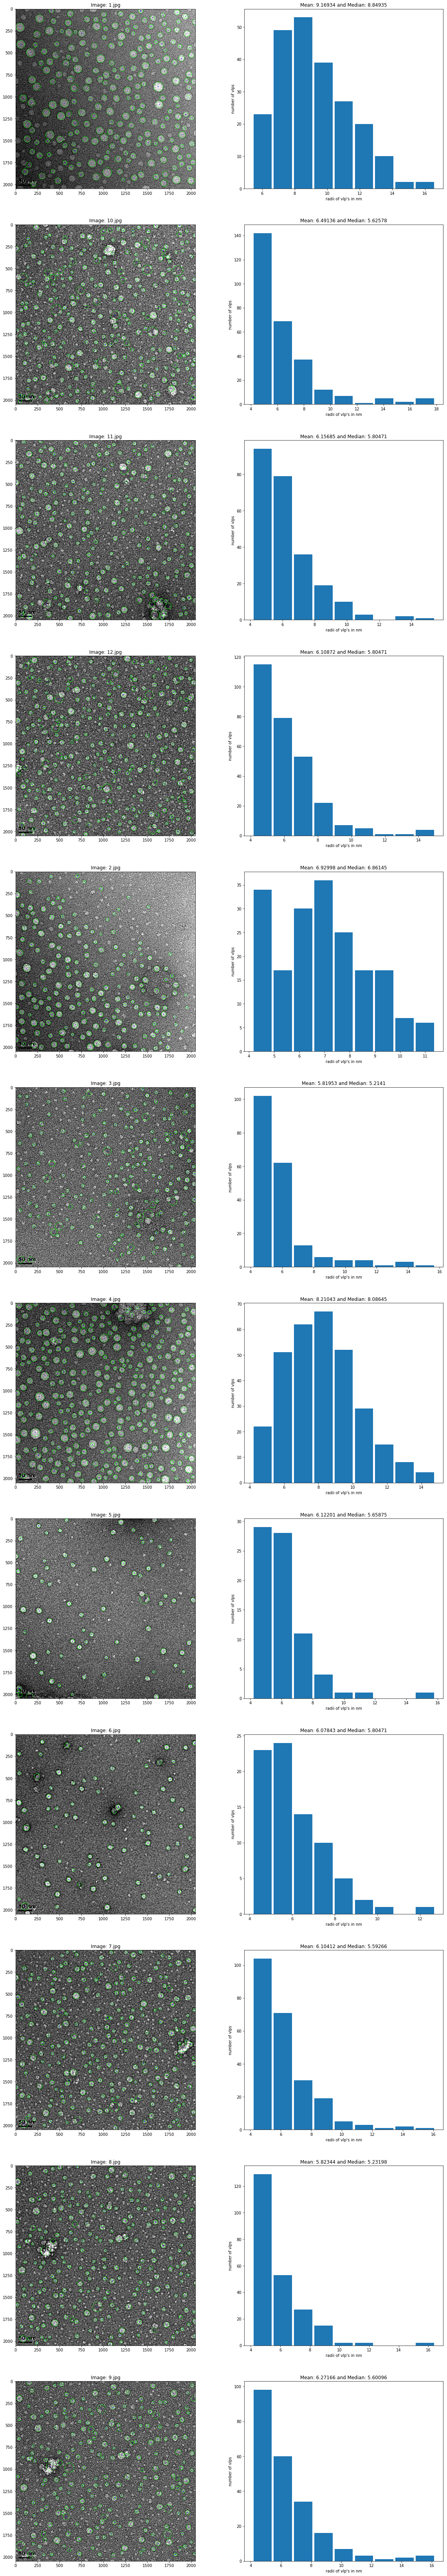

In [6]:
# ---- Enter parameters here -------

n_bins = 9

# --------------------------------

num_rows = len(filenames)
num_cols = 2

fig, axes1 = plt.subplots(num_rows,num_cols,figsize=(20,num_rows*10))
for j in range(num_rows):
    axes1[j][0].imshow(images[j])
    axes1[j][0].set_title("Image: "+ filenames[j])
    axes1[j][1].hist(radii[j],rwidth=0.9,bins=n_bins)
    axes1[j][1].set_xlabel("radii of vlp's in nm")
    axes1[j][1].set_ylabel("number of vlps")
    axes1[j][1].set_title("Mean: "+ str(np.mean(radii[j]))+ " and Median: "+str(np.median(radii[j])))